In [1]:
from google.colab import files
uploaded = files.upload()

Saving up_genes.txt to up_genes.txt


In [6]:
files.upload()

Saving down_genes.txt to down_genes (1).txt


{'down_genes (1).txt': b'LOC_Os01g03020\nLOC_Os01g03570\nLOC_Os01g08860\nLOC_Os01g05090\nLOC_Os01g12340\nLOC_Os09g32500\nLOC_Os01g05610\nLOC_Os01g10140\nLOC_Os03g30430\nLOC_Os01g07950\nLOC_Os01g14770\nLOC_Os02g55060\nLOC_Os01g13260\nLOC_Os04g40040\nLOC_Os04g18090\nLOC_Os10g02814\nLOC_Os01g12374\nLOC_Os01g06010\nLOC_Os05g37330\nLOC_Os02g18410\nLOC_Os01g10580\nLOC_Os03g01270\nLOC_Os04g44780\nLOC_Os04g41238\nLOC_Os05g06770\nLOC_Os03g46770\nLOC_Os01g08890\nLOC_Os06g03514\nLOC_Os01g07620\nLOC_Os03g44560\nLOC_Os08g39330\nLOC_Os01g12650\nLOC_Os04g40180\nLOC_Os05g36150\nLOC_Os01g08600\nLOC_Os11g41130\nLOC_Os04g33830\nLOC_Os04g59330\nLOC_Os12g40520\nLOC_Os02g43150\nLOC_Os03g63970\nLOC_Os07g41280\nLOC_Os02g13400\nLOC_Os04g48870\nLOC_Os05g47540\nLOC_Os02g07410\nLOC_Os07g07240\nLOC_Os07g08790\nLOC_Os03g16010\nLOC_Os01g13390\nLOC_Os01g16890\nLOC_Os08g04270\nLOC_Os11g14220\nLOC_Os02g32030\nLOC_Os03g27320\nLOC_Os03g09290\nLOC_Os10g25310\nLOC_Os03g08440\nLOC_Os11g43970\nLOC_Os02g25230\nLOC_Os03g29190\

In [4]:
files.upload()

Saving rap_table.txt to rap_table.txt


{'rap_table.txt': b'\n\nOs01g0100100\tLOC_Os01g01010.1,LOC_Os01g01010.2\nOs01g0100200\tLOC_Os01g01019.1\nOs01g0100300\tNone\nOs01g0100400\tLOC_Os01g01030.1\nOs01g0100466\tNone\nOs01g0100500\tLOC_Os01g01040.1,LOC_Os01g01040.2,LOC_Os01g01040.3,LOC_Os01g01040.4\nOs01g0100600\tLOC_Os01g01050.1,LOC_Os01g01050.2\nOs01g0100650\tNone\nOs01g0100700\tLOC_Os01g01060.1\nOs01g0100800\tLOC_Os01g01070.1,LOC_Os01g01070.2,LOC_Os01g01070.3\nOs01g0100900\tLOC_Os01g01080.1,LOC_Os01g01080.2,LOC_Os01g01080.3\nOs01g0101150\tLOC_Os01g01115.1\nOs01g0101175\tNone\nOs01g0101200\tLOC_Os01g01120.1\nOs01g0101300\tLOC_Os01g01130.1\nOs01g0101500\tLOC_Os01g01140.1\nOs01g0101600\tLOC_Os01g01150.1,LOC_Os01g01150.2,LOC_Os01g01150.3\nOs01g0101700\tLOC_Os01g01160.1\nOs01g0101800\tLOC_Os01g01170.1\nOs01g0101850\tNone\nOs01g0101900\tLOC_Os01g01180.1\nOs01g0102000\tLOC_Os01g01190.1\nOs01g0102300\tLOC_Os01g01280.1\nOs01g0102400\tLOC_Os01g01290.1\nOs01g0102500\tLOC_Os01g01295.1\nOs01g0102600\tLOC_Os01g01302.1\nOs01g0102700\tLOC

In [7]:
# Cell 1 — build mapping and map up/down lists
import pandas as pd, re, gzip
from pathlib import Path

# Paths (should already be uploaded into /content)
rap_path = Path("/content/rap_table.txt")   # change if different name; supports .gz if needed
up_path  = Path("/content/up_genes.txt")
down_path= Path("/content/down_genes.txt")

# read RAP (supports .gz)
def read_text(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"{p} not found in /content. Upload first.")
    s = str(p)
    if s.endswith(".gz"):
        return gzip.open(s, "rt", encoding="utf-8", errors="replace").read()
    return p.read_text(encoding="utf-8", errors="replace")

print("Reading RAP file:", rap_path.name)
raw = read_text(rap_path)

# parse lines (tab or whitespace separated)
lines = [ln for ln in raw.splitlines() if ln.strip()]
rows = []
for ln in lines:
    if "\t" in ln:
        left, right = ln.split("\t", 1)
    elif " " in ln:
        left, right = ln.split(None, 1)
    else:
        continue
    rows.append((left.strip(), right.strip()))

# expand mapping
data = []
for msu, loc_field in rows:
    if not loc_field or loc_field.lower() in ("none","na","-"):
        continue
    parts = [p.strip() for p in re.split(r"[,;]+|\s+", loc_field) if p.strip()]
    for p in parts:
        base = re.sub(r"\.\d+$", "", p)   # strip isoform suffix .1, .2
        data.append({"MSU_ID": msu, "LOC_ID": base, "LOC_raw": p})

map_df = pd.DataFrame(data).drop_duplicates().reset_index(drop=True)
map_df.to_csv("/content/loc_to_msu.csv", index=False)
print("Saved mapping -> /content/loc_to_msu.csv  rows:", len(map_df))
print("Unique LOCs:", map_df['LOC_ID'].nunique())

# read up/down lists (if present) and clean isoform suffix
def read_list(path):
    if not path.exists():
        return []
    s = pd.read_csv(path, header=None, dtype=str)[0].astype(str).str.strip().tolist()
    return [re.sub(r"\.\d+$", "", x) for x in s]

up_list = read_list(up_path)
down_list = read_list(down_path)
print("UP list length (raw):", len(up_list))
print("DOWN list length (raw):", len(down_list))

# map lists
if up_list:
    up_df = pd.DataFrame({"LOC_ID": up_list})
    up_map = up_df.merge(map_df[["LOC_ID","MSU_ID"]].drop_duplicates(), on="LOC_ID", how="left")
    up_map.to_csv("/content/up_mapped.csv", index=False)
else:
    up_map = pd.DataFrame(columns=["LOC_ID","MSU_ID"])

if down_list:
    down_df = pd.DataFrame({"LOC_ID": down_list})
    down_map = down_df.merge(map_df[["LOC_ID","MSU_ID"]].drop_duplicates(), on="LOC_ID", how="left")
    down_map.to_csv("/content/down_mapped.csv", index=False)
else:
    down_map = pd.DataFrame(columns=["LOC_ID","MSU_ID"])

mapped_up = sorted(set(up_map["MSU_ID"].dropna().tolist())) if not up_map.empty else []
mapped_down = sorted(set(down_map["MSU_ID"].dropna().tolist())) if not down_map.empty else []

print("Mapped UP -> MSU unique:", len(mapped_up))
print("Mapped DOWN -> MSU unique:", len(mapped_down))
print("Files written: /content/loc_to_msu.csv, /content/up_mapped.csv, /content/down_mapped.csv")
# quick preview
print("\nPreview mapping (first 8 rows):")
print(map_df.head(8).to_string(index=False))

Reading RAP file: rap_table.txt
Saved mapping -> /content/loc_to_msu.csv  rows: 67545
Unique LOCs: 55801
UP list length (raw): 60
DOWN list length (raw): 166
Mapped UP -> MSU unique: 56
Mapped DOWN -> MSU unique: 166
Files written: /content/loc_to_msu.csv, /content/up_mapped.csv, /content/down_mapped.csv

Preview mapping (first 8 rows):
      MSU_ID         LOC_ID          LOC_raw
Os01g0100100 LOC_Os01g01010 LOC_Os01g01010.1
Os01g0100100 LOC_Os01g01010 LOC_Os01g01010.2
Os01g0100200 LOC_Os01g01019 LOC_Os01g01019.1
Os01g0100400 LOC_Os01g01030 LOC_Os01g01030.1
Os01g0100500 LOC_Os01g01040 LOC_Os01g01040.1
Os01g0100500 LOC_Os01g01040 LOC_Os01g01040.2
Os01g0100500 LOC_Os01g01040 LOC_Os01g01040.3
Os01g0100500 LOC_Os01g01040 LOC_Os01g01040.4


In [8]:
# Cell 2 — run g:Profiler enrichment (GO+KEGG) and save CSVs
!pip -q install gprofiler-official

from gprofiler import GProfiler
import pandas as pd
from pathlib import Path

gp = GProfiler(return_dataframe=True)

# load mapped files (created by Cell 1)
up_map = pd.read_csv("/content/up_mapped.csv") if Path("/content/up_mapped.csv").exists() else pd.DataFrame()
down_map = pd.read_csv("/content/down_mapped.csv") if Path("/content/down_mapped.csv").exists() else pd.DataFrame()

def get_query(df):
    if df is None or df.empty:
        return []
    if "MSU_ID" in df.columns and df["MSU_ID"].notna().any():
        return df["MSU_ID"].dropna().astype(str).unique().tolist()
    return df["LOC_ID"].dropna().astype(str).unique().tolist()

up_query = get_query(up_map)
down_query = get_query(down_map)

print("UP query size:", len(up_query))
print("DOWN query size:", len(down_query))

# run enrichment only if we have queries
if len(up_query):
    print("Running g:Profiler for UP...")
    res_up = gp.profile(organism='osativa', query=up_query, sources=['GO:BP','GO:MF','GO:CC','KEGG'])
    res_up.to_csv("/content/gprofiler_up.csv", index=False)
    display(res_up.head(8))
else:
    print("No UP query found — skipping UP enrichment.")

if len(down_query):
    print("Running g:Profiler for DOWN...")
    res_down = gp.profile(organism='osativa', query=down_query, sources=['GO:BP','GO:MF','GO:CC','KEGG'])
    res_down.to_csv("/content/gprofiler_down.csv", index=False)
    display(res_down.head(8))
else:
    print("No DOWN query found — skipping DOWN enrichment.")

print("Saved: /content/gprofiler_up.csv (if any), /content/gprofiler_down.csv (if any)")

UP query size: 55
DOWN query size: 165
Running g:Profiler for UP...


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0000785,chromatin,0.044841,True,"""The ordered and organized complex of DNA, pro...",193,32,4,16760,0.125000,0.020725,query_1,"[GO:0005694, GO:0110165]"
1,KEGG,KEGG:03410,Base excision repair,0.049884,True,Base excision repair,31,9,2,3695,0.222222,0.064516,query_1,[KEGG:00000]


Running g:Profiler for DOWN...


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:MF,GO:0005198,structural molecule activity,0.000048,True,"""The action of a molecule that contributes to ...",492,90,14,18055,0.155556,0.028455,query_1,[GO:0003674]
1,GO:CC,GO:0005829,cytosol,0.000079,True,"""The part of the cytoplasm that does not conta...",1008,102,21,16760,0.205882,0.020833,query_1,"[GO:0005737, GO:0110165]"
2,GO:CC,GO:0030904,retromer complex,0.000595,True,"""A conserved hetero-pentameric membrane-associ...",6,102,3,16760,0.029412,0.500000,query_1,"[GO:0012505, GO:0098796]"
3,GO:CC,GO:0043228,membraneless organelle,0.001183,True,"""Organized structure of distinctive morphology...",1608,102,25,16760,0.245098,0.015547,query_1,[GO:0043226]
4,GO:CC,GO:0043232,intracellular membraneless organelle,0.001183,True,"""Organized structure of distinctive morphology...",1608,102,25,16760,0.245098,0.015547,query_1,"[GO:0043228, GO:0043229]"
5,GO:CC,GO:0032991,protein-containing complex,0.002653,True,"""A stable assembly of two or more macromolecul...",2742,102,34,16760,0.333333,0.012400,query_1,[GO:0005575]
6,GO:CC,GO:0005737,cytoplasm,0.003283,True,"""The contents of a cell excluding the plasma m...",6606,102,61,16760,0.598039,0.009234,query_1,"[GO:0005622, GO:0110165]"
7,GO:BP,GO:0000226,microtubule cytoskeleton organization,0.005818,True,"""A process that is carried out at the cellular...",130,94,7,16058,0.074468,0.053846,query_1,"[GO:0007010, GO:0007017]"


Saved: /content/gprofiler_up.csv (if any), /content/gprofiler_down.csv (if any)


Loaded rows — UP: 2 DOWN: 13
Prepared plotting rows — UP: 2 DOWN: 13


/tmp/ipython-input-1067255468.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlBu_r")


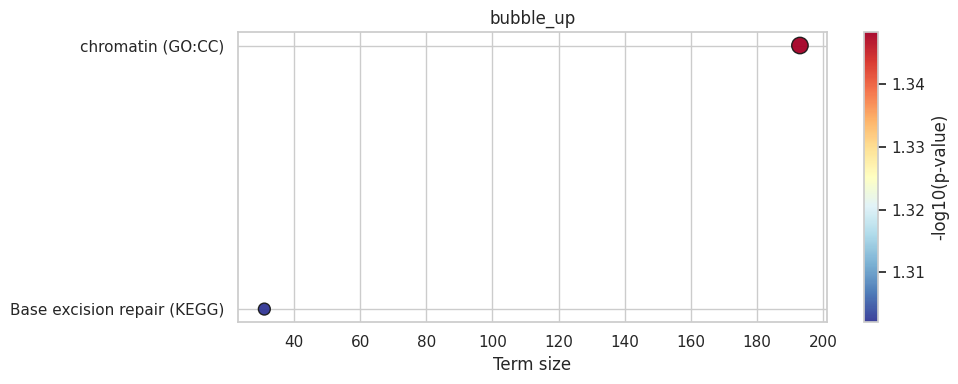

Saved: /content/bubble_up.png


/tmp/ipython-input-1067255468.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlBu_r")


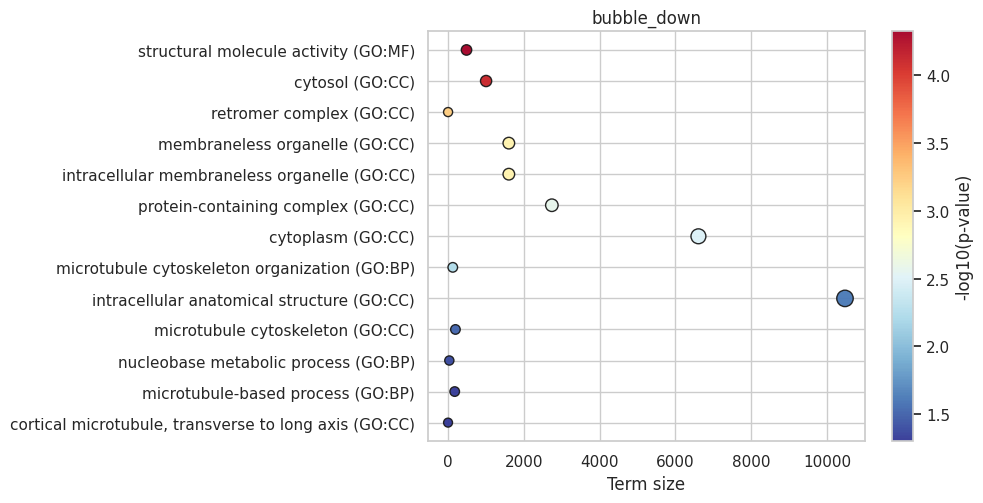

Saved: /content/bubble_down.png

Done!


In [10]:
# ============================
#   COMPLETE BUBBLE PLOT PIPELINE
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from pathlib import Path

sns.set(style="whitegrid")

# -----------------------------
# Load gProfiler results
# -----------------------------
up_fp   = Path("/content/gprofiler_up.csv")
down_fp = Path("/content/gprofiler_down.csv")

def load_gp(fp):
    if not fp.exists():
        print("File missing:", fp)
        return pd.DataFrame()
    df = pd.read_csv(fp)

    # Normalize column names
    rename_map = {
        "p_value":"p_value",
        "p-value":"p_value",
        "pvalue":"p_value",
        "intersection_size":"intersection_size",
        "overlap_size":"intersection_size",
        "term_size":"term_size",
        "name":"name",
        "term_name":"name",
        "source":"source",
        "significant":"significant"
    }
    # fix keys that differ in case
    newmap = {}
    for col in df.columns:
        lc = col.lower().replace(" ", "_")
        if lc in ["p_value","pvalue","p-value"]:
            newmap[col] = "p_value"
        elif lc in ["intersection_size","overlap"]:
            newmap[col] = "intersection_size"
        elif lc in ["term_size"]:
            newmap[col] = "term_size"
        elif lc in ["name","term_name"]:
            newmap[col] = "name"
        elif lc == "source":
            newmap[col] = "source"
        elif lc == "significant":
            newmap[col] = "significant"
    df = df.rename(columns=newmap)

    # Convert numerics
    for col in ["p_value","intersection_size","term_size"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

up = load_gp(up_fp)
down = load_gp(down_fp)

print("Loaded rows — UP:", len(up), "DOWN:", len(down))

# -----------------------------
# Prepare plotting table
# -----------------------------
def prepare_plot_table(df, topK=15):
    if df.empty:
        return df

    # Use significant rows; if too few, fallback to p-value ranking
    sig_mask = False
    if "significant" in df.columns:
        sig_mask = df["significant"].astype(str).str.upper().isin(["TRUE","1","T"])
    n_sig = sig_mask.sum() if hasattr(sig_mask, "sum") else 0

    if n_sig >= 5:
        dfp = df[sig_mask].copy()
    else:
        dfp = df.sort_values("p_value").head(max(topK, 20)).copy()

    dfp = dfp.sort_values("p_value").head(topK).copy()

    if "name" not in dfp.columns:
        dfp["name"] = dfp.iloc[:,0].astype(str)

    dfp = dfp.dropna(subset=["p_value"])
    dfp["-log10p"] = -np.log10(dfp["p_value"].replace(0, 1e-300))
    dfp["term_label"] = dfp.apply(
        lambda r: f"{r['name']} ({r.get('source','')})", axis=1
    )
    dfp = dfp.sort_values("-log10p", ascending=False).reset_index(drop=True)
    return dfp

up_plot = prepare_plot_table(up, topK=15)
down_plot = prepare_plot_table(down, topK=15)

print("Prepared plotting rows — UP:", len(up_plot), "DOWN:", len(down_plot))

# Save tables
up_plot.to_csv("/content/gprofiler_plot_up.csv", index=False)
down_plot.to_csv("/content/gprofiler_plot_down.csv", index=False)

# -----------------------------
# Bubble plot function
# -----------------------------
def bubble_plot(df_plot, out_path="/content/bubble.png", figsize=(10, 0.4*15)):
    if df_plot.empty:
        print("Nothing to plot for:", out_path)
        return

    plt.figure(figsize=(10, max(4,0.4*len(df_plot))))

    sizes = df_plot["intersection_size"].fillna(1).values
    sizes_scaled = 100 * ((sizes - sizes.min() + 1) / (sizes.max() - sizes.min() + 1)) + 40

    norm = plt.Normalize(df_plot["-log10p"].min(), df_plot["-log10p"].max())
    cmap = cm.get_cmap("RdYlBu_r")

    y_pos = np.arange(len(df_plot))

    sc = plt.scatter(
        df_plot["term_size"].fillna(0),
        y_pos,
        s=sizes_scaled,
        c=df_plot["-log10p"],
        cmap=cmap,
        norm=norm,
        alpha=0.95,
        edgecolor="k"
    )

    plt.yticks(y_pos, df_plot["term_label"])
    plt.gca().invert_yaxis()
    plt.xlabel("Term size")

    cbar = plt.colorbar(sc)
    cbar.set_label("-log10(p-value)")

    plt.title(Path(out_path).stem)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

    print("Saved:", out_path)

# -----------------------------
# Generate bubble plots
# -----------------------------
bubble_plot(up_plot, "/content/bubble_up.png")
bubble_plot(down_plot, "/content/bubble_down.png")

print("\nDone!")

In [ ]:
library(ggplot2)
library(dplyr)

# assume gp_up is your gProfiler data frame
# if not, replace gp_up with your dataframe variable
df <- gp_up

# Filter only significant terms
df_sig <- df %>% filter(significant == TRUE)

# If no significant terms, plot the top 15 by p-value
if (nrow(df_sig) == 0) {
  df_sig <- df %>% arrange(p_value) %>% head(15)
}

# Bubble plot
p1 <- ggplot(df_sig, aes(x = term_size,
                         y = reorder(name, -log10(p_value)),
                         size = intersection_size,
                         color = -log10(p_value))) +
  geom_point(alpha = 0.8) +
  scale_color_gradient(low = "blue", high = "red") +
  labs(
    title = "GO/KEGG Enrichment – Bubble Plot",
    x = "Term Size (number of genes in database)",
    y = "Enriched Term",
    color = "-log10(p-value)",
    size = "Intersection Size"
  ) +
  theme_bw(base_size = 14)

print(p1)

ggsave("bubble_enrichment.png", p1, width = 10, height = 8, dpi = 300)

ERROR: Error: object 'gp_up' not found
